In [2]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [4]:
n = 11 
#novel number
t = "Alice_Wonderland"
#novel name
s = 1
#how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [5]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [8]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [9]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [10]:
df_novel.head()

,0
0,Down the Rabbit-Hole Alice was beginning to g...
1,So she was considering in her own mind (as wel...
2,There was nothing so VERY remarkable in that; ...
3,Oh dear!
4,I shall be late!'


Create the wrd_length and total_char columns.

In [11]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [12]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [13]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [14]:
df_novel.head()

,0,wrd_length,total_char
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109
3,Oh dear!,"[2, 4]",6
4,I shall be late!',"[1, 5, 2, 4]",12


Create syllable count column

In [15]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [16]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [17]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [18]:
df_novel['syl_count'] = syl_count_arr

In [20]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,"[1, 1, 3, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, ..."
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,"[1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,"[1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, ..."
3,Oh dear!,"[2, 4]",6,"[1, 2]"
4,I shall be late!',"[1, 5, 2, 4]",12,"[1, 1, 1, 1]"


In [ ]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [21]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [22]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [23]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [24]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [25]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [26]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [27]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,[1 1 3 2 1 3 1 1 2 1 1 2 1 1 2 1 1 1 1 1 2 2 1...,83,-0.337778
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,[1 0 1 4 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 2 1...,70,0.031250
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,[1 1 2 1 2 3 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1...,39,0.650000
3,Oh dear!,"[2, 4]",6,[1 2],3,0.000000
4,I shall be late!',"[1, 5, 2, 4]",12,[1 1 1 1],4,-0.375000


Create cluster dataframe - remove columns that can't be used

In [28]:
df_cluster = df_novel.drop('wrd_length', 1)

In [29]:
df_cluster = df_cluster.drop('syl_count', 1)

In [30]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778
1,So she was considering in her own mind (as wel...,229,70,0.031250
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000
3,Oh dear!,6,3,0.000000
4,I shall be late!',12,4,-0.375000


Create 20 clusters on scaled data

In [31]:
X = df_cluster.drop(0, axis=1)

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [34]:
df_cluster['cluster'] = km.labels_

In [35]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,45.286792,13.871698,0.000471
1,221.269231,68.461538,-0.162601
2,138.440000,42.720000,0.285162
3,476.000000,143.000000,0.016157
4,36.765957,11.234043,0.514696
5,53.466667,16.733333,-0.863611
6,134.804598,41.149425,-0.056712
7,36.655556,11.188889,-0.248228
8,223.033333,67.200000,0.158646


In [36]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [37]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

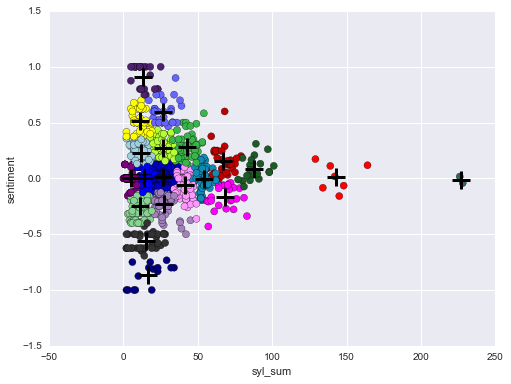

In [38]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [39]:
df_cluster_3 = df_cluster

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,1
1,So she was considering in her own mind (as wel...,229,70,0.031250,8
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,16
3,Oh dear!,6,3,0.000000,11
4,I shall be late!',12,4,-0.375000,7


In [40]:
X = df_cluster_3.drop(0, axis=1)

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [43]:
df_cluster_3['cluster'] = km.labels_

In [44]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,42.400971,13.063107,0.007878
1,49.281437,15.089820,0.091732
2,188.530534,57.809160,0.009628


Create 3 Clusters with no syl_sum

In [45]:
df_cluster_no_syl = df_cluster

In [46]:
df_cluster_no_syl.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,2
1,So she was considering in her own mind (as wel...,229,70,0.031250,2
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,0
3,Oh dear!,6,3,0.000000,0
4,I shall be late!',12,4,-0.375000,0


In [47]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [48]:
X = df_cluster_no_syl.drop(0, axis=1)

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [51]:
df_cluster_no_syl['cluster'] = km.labels_

In [52]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,64.120192,0.460462
1,40.408658,-0.049479
2,188.285171,0.010067


Create 5 Clusters

In [53]:
df_cluster_5 = df_cluster

In [54]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,2
1,So she was considering in her own mind (as wel...,229,70,0.031250,2
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,0
3,Oh dear!,6,3,0.000000,0
4,I shall be late!',12,4,-0.375000,0


In [55]:
X = df_cluster_5.drop(0, axis=1)

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [58]:
df_cluster_5['cluster'] = km.labels_

In [59]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,57.882353,17.789216,-0.336462
1,176.541502,54.162055,0.017230
2,36.579545,11.227273,0.014265
3,529.555556,161.666667,0.009813
4,67.083333,20.760417,0.477386


Find ideal amount of clusters for novel

In [ ]:
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

In [ ]:
k_range = range(2,150)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

In [ ]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

Find Sentiment Pattern - need to work on this code to make it more universal.

20 pieces

In [60]:
df_novel['total_char'].sum()

109528

In [61]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [62]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [63]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:60]
df_novel['total_char'][60:115]
df_novel['total_char'][115:192]
df_novel['total_char'][192:264]
df_novel['total_char'][264:352]
df_novel['total_char'][352:443]
df_novel['total_char'][443:505]
df_novel['total_char'][505:586]
df_novel['total_char'][586:655]
df_novel['total_char'][655:741]
df_novel['total_char'][741:843]
df_novel['total_char'][843:938]
df_novel['total_char'][938:1019]
df_novel['total_char'][1019:1078]
df_novel['total_char'][1078:1164]
df_novel['total_char'][1164:1272]
df_novel['total_char'][1272:1363]
df_novel['total_char'][1363:1446]
df_novel['total_char'][1446:1532]
df_novel['total_char'][1532:1623]


In [64]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
60
0.0471425918603
60
115
0.0291150727417
115
192
-0.00841434619931
192
264
0.0203819494549
264
352
0.0321346463143
352
443
0.0297514928473
443
505
0.0152957648113
505
586
0.00289304584631
586
655
0.0117530836811
655
741
-0.0366886297918
741
843
0.0155608319717
843
938
0.0100220247589
938
1019
-0.0142449794147
1019
1078
0.0350751126508
1078
1164
0.0387175464501
1164
1272
0.0322697970111
1272
1363
0.0647142857143
1363
1446
0.0876633199465
1446
1532
0.0219613652793
1532
1623
0.0693888452817


In [65]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.04714259  0.02911507 -0.00841435  0.02038195  0.03213465  0.02975149
  0.01529576  0.00289305  0.01175308 -0.03668863  0.01556083  0.01002202
 -0.01424498  0.03507511  0.03871755  0.0322698   0.06471429  0.08766332
  0.02196137  0.06938885]


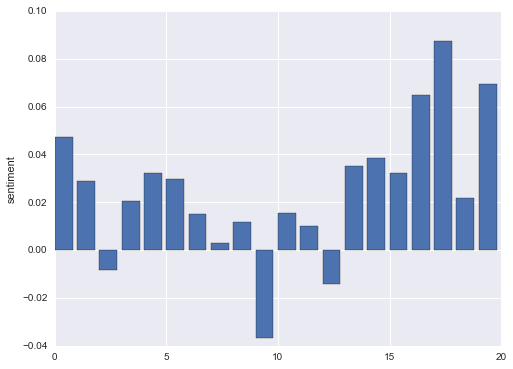

In [66]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern

In [67]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -250
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [68]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
1621,"But her sister sat still just as she left her,...","[3, 3, 6, 3, 5, 4, 2, 3, 4, 3, 7, 3, 4, 2, 3, ...",549,"[1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 3, 1, 2, 1, 1, ...",164,0.117857
1622,The long grass rustled at her feet as the Whit...,"[3, 4, 5, 7, 2, 3, 4, 2, 3, 5, 6, 7, 2, 3, 10,...",516,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, ...",148,-0.065000
1623,"So she sat on, with closed eyes, and half beli...","[2, 3, 3, 2, 4, 6, 4, 3, 4, 8, 7, 2, 10, 6, 3,...",504,"[1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 2, 1, 3, 1, 0, ...",145,-0.158333
1624,"Lastly, she pictured to herself how this same ...","[6, 3, 8, 2, 7, 3, 4, 4, 6, 6, 2, 4, 5, 2, 3, ...",441,"[2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, ...",129,0.173333
1625,THE END,"[3, 3]",6,"[1, 1]",2,0.000000


need to fix this piece of code

In [69]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:489]
df_novel['total_char'][489:1049]
df_novel['total_char'][1049:1624]


KeyboardInterrupt: 

In [70]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
489
0.0210658632327
489
1049
0.00212585410002
1049
1624
0.0514973242145


In [71]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.02106586  0.00212585  0.05149732]


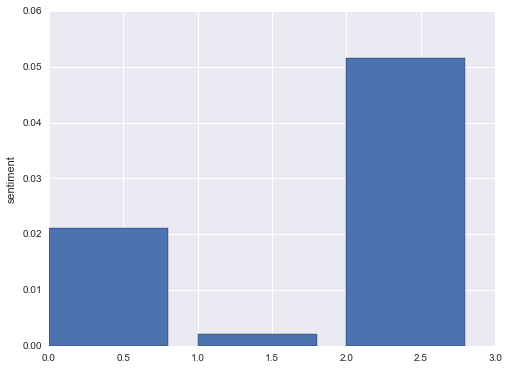

In [72]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

In [73]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,"[1, 1, 3, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...",83,-0.337778
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,"[1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...",70,0.031250
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,"[1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, ...",39,0.650000
3,Oh dear!,"[2, 4]",6,"[1, 2]",3,0.000000
4,I shall be late!',"[1, 5, 2, 4]",12,"[1, 1, 1, 1]",4,-0.375000


In [74]:
for i in df_novel[0][655:741]:
    print i

I--'  'Oh, don't bother ME,' said the Duchess; 'I never could abide figures!'
And with that she began nursing her child again, singing a sort of lullaby to it as she did so, and giving it a violent shake at the end of every line:     'Speak roughly to your little boy,     And beat him when he sneezes:    He only does it to annoy,     Because he knows it teases.'
CHORUS.
(In which the cook and the baby joined):--         'Wow!
wow!
wow!'
While the Duchess sang the second verse of the song, she kept tossing the baby violently up and down, and the poor little thing howled so, that Alice could hardly hear the words:--     'I speak severely to my boy,     I beat him when he sneezes;    For he can thoroughly enjoy     The pepper when he pleases!'
CHORUS.
'Wow!
wow!
wow!'
'Here!
you may nurse it a bit, if you like!'
the Duchess said to Alice, flinging the baby at her as she spoke.
'I must go and get ready to play croquet with the Queen,' and she hurried out of the room.
The cook threw a fryin

In [42]:
for i in df_novel['sentiment'][655:741]:
    print i

0.0
-0.271875
0.0
0.125
0.125
0.125
-0.190674603175
0.0
0.125
0.125
0.125
0.0
0.0
0.0
0.2
0.0
-0.1875
-0.034375
0.0214285714286
0.05
-0.021875
0.0
-0.325
0.1625
0.0
0.0
0.0833333333333
0.0
-0.418055555556
0.0
-0.477777777778
-0.0416666666667
-0.114351851852
-0.1
-0.00446428571429
0.0
0.411666666667
-0.09375
0.3
0.0
0.7
0.2
0.0
-0.05
0.1125
0.0
0.136363636364
-0.0130952380952
-0.625
-0.625
-0.625
-0.625
-0.625
-0.625
0.0
0.0
-0.625
0.3125
0.0
0.0
0.0
0.0
-0.625
0.0
0.0
0.0
0.26
0.0
-0.05
0.0
0.0
0.0
0.1
0.0333333333333
0.0
-0.072601010101
0.055
0.0
0.0
0.0
0.0
-0.00714285714286
0.0
0.0
0.1875
0.242857142857


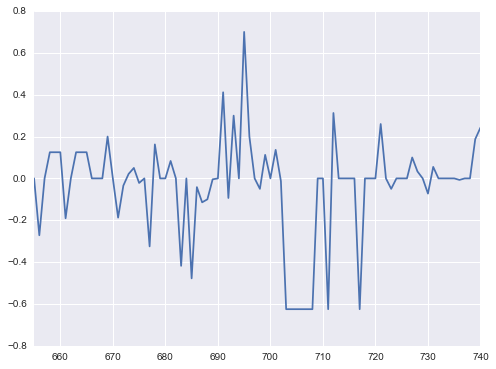

In [76]:
df_novel['sentiment'][655:741].plot()

In [78]:
for i in df_novel[0][690:700]:
    print i

The Cat only grinned when it saw Alice.
It looked good-natured, she thought: still it had VERY long claws and a great many teeth, so she felt that it ought to be treated with respect.
'Cheshire Puss,' she began, rather timidly, as she did not at all know whether it would like the name: however, it only grinned a little wider.
'Come, it's pleased so far,' thought Alice, and she went on.
'Would you tell me, please, which way I ought to go from here?'
'That depends a good deal on where you want to get to,' said the Cat.
'I don't much care where--' said Alice.
'Then it doesn't matter which way you go,' said the Cat.  '
--so long as I get SOMEWHERE,' Alice added as an explanation.
'Oh, you're sure to do that,' said the Cat, 'if you only walk long enough.'


In [77]:
for i in df_novel[0][700:710]:
    print i

Alice felt that this could not be denied, so she tried another question.
'What sort of people live about here?'
'In THAT direction,' the Cat said, waving its right paw round, 'lives a Hatter: and in THAT direction,' waving the other paw, 'lives a March Hare.
Visit either you like: they're both mad.'
'But I don't want to go among mad people,' Alice remarked.
'Oh, you can't help that,' said the Cat: 'we're all mad here.
I'm mad.
You're mad.'
'How do you know I'm mad?'
said Alice.


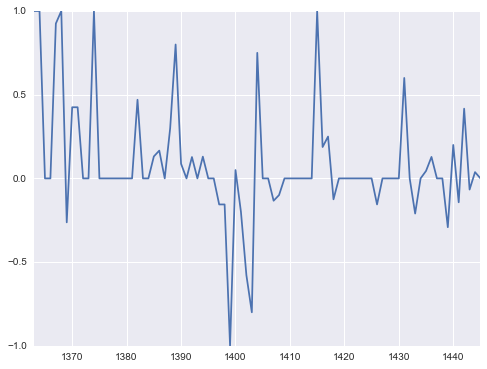

In [79]:
df_novel['sentiment'][1363:1446].plot()

In [80]:
for i in df_novel[0][1363:1446]:
    print i

Soup of the evening, beautiful Soup!
Soup of the evening, beautiful Soup!
Beau--ootiful Soo--oop!
Beau--ootiful Soo--oop!
Soo--oop of the e--e--evening,      Beautiful, beautiful Soup!
'Beautiful Soup!
Who cares for fish,    Game, or any other dish?
Who would not give all else for two    Pennyworth only of beautiful Soup?
Pennyworth only of beautiful Soup?
Beau--ootiful Soo--oop!
Beau--ootiful Soo--oop!
Soo--oop of the e--e--evening,      Beautiful, beauti--FUL SOUP!'
'Chorus again!'
cried the Gryphon, and the Mock Turtle had just begun to repeat it, when a cry of 'The trial's beginning!'
was heard in the distance.
'Come on!'
cried the Gryphon, and, taking Alice by the hand, it hurried off, without waiting for the end of the song.
'What trial is it?'
Alice panted as she ran; but the Gryphon only answered 'Come on!'
and ran the faster, while more and more faintly came, carried on the breeze that followed them, the melancholy words:--     'Soo--oop of the e--e--evening,      Beautiful, b

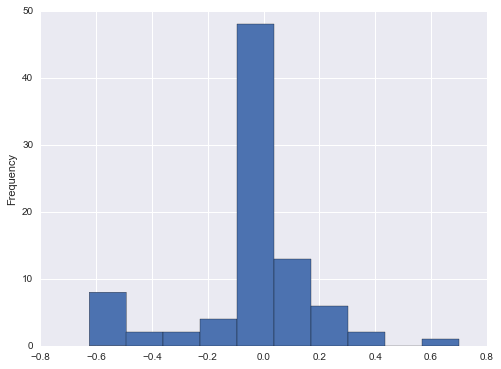

In [45]:
df_novel['sentiment'][655:741].plot(kind='hist')

In [46]:
df_novel['sentiment'].min()

-1.0

In [54]:
high = df_novel[df_novel['sentiment'] > .9]

In [55]:
high

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
13,How brave they'll all think me at home!,"[3, 5, 4, 3, 3, 5, 2, 2, 4]",31,"[1, 1, 1, 0, 1, 1, 1, 1, 1]",8,1.000
118,"Ah, THAT'S the great puzzle!'","[2, 4, 2, 3, 5, 6]",22,"[1, 1, 0, 1, 2, 1]",6,1.000
239,"'Why,' said the Dodo, 'the best way to explain...","[4, 4, 3, 4, 4, 4, 3, 2, 7, 2, 2, 2, 2, 2]",45,"[1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1]",15,1.000
442,I think that will be the best plan.',"[1, 5, 4, 4, 2, 3, 4, 4]",27,"[1, 1, 1, 1, 1, 1, 1, 1]",8,1.000
520,'It is a very good height indeed!',"[3, 2, 1, 4, 4, 6, 6]",26,"[1, 1, 1, 2, 1, 1, 1]",8,1.000
784,"'It was the BEST butter,' the March Hare meekl...","[3, 3, 3, 4, 6, 3, 5, 4, 6, 7]",44,"[1, 1, 1, 1, 2, 1, 1, 1, 2, 2]",13,1.000
1363,"Soup of the evening, beautiful Soup!","[4, 2, 3, 7, 9, 4]",29,"[1, 1, 1, 3, 4, 1]",11,1.000
1364,"Soup of the evening, beautiful Soup!","[4, 2, 3, 7, 9, 4]",29,"[1, 1, 1, 3, 4, 1]",11,1.000
1367,"Soo--oop of the e--e--evening, Beautiful,...","[3, 3, 2, 3, 1, 1, 7, 9, 9, 4]",42,"[1, 1, 1, 1, 1, 1, 3, 4, 4, 1]",18,0.925
1368,'Beautiful Soup!,"[10, 4]",14,"[4, 1]",5,1.000


In [57]:
for i in high[0]:
    print i
    print '****'

How brave they'll all think me at home!
****
Ah, THAT'S the great puzzle!'
****
'Why,' said the Dodo, 'the best way to explain it is to do it.'
****
I think that will be the best plan.'
****
'It is a very good height indeed!'
****
'It was the BEST butter,' the March Hare meekly replied.
****
Soup of the evening, beautiful Soup!
****
Soup of the evening, beautiful Soup!
****
Soo--oop of the e--e--evening,      Beautiful, beautiful Soup!
****
'Beautiful Soup!
****
Soo--oop of the e--e--evening,      Beautiful, beauti--FUL SOUP!'
****
'There's a great deal to come before that!'
****
So Alice got up and ran off, thinking while she ran, as well she might, what a wonderful dream it had been.
****


In [58]:
low = df_novel[df_novel['sentiment'] < -.9]

In [59]:
low

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
622,"'It's really dreadful,' she muttered to hersel...","[3, 2, 6, 8, 3, 8, 2, 7, 4, 3, 3, 3, 9, 5]",66,"[1, 0, 3, 3, 0, 2, 1, 2, 0, 1, 1, 1, 3, 1]",19,-1.0
796,Alice felt dreadfully puzzled.,"[5, 4, 10, 7]",26,"[2, 1, 4, 1]",8,-1.0
837,'How dreadfully savage!',"[4, 10, 6]",20,"[1, 4, 2]",7,-1.0
952,'Idiot!',[6],6,[2],2,-1.0
1399,'Stupid things!',"[7, 6]",13,"[2, 1]",3,-1.0


In [62]:
for i in low[0]:
    print i
    print '***'

'It's really dreadful,' she muttered to herself, 'the way all the creatures argue.
***
Alice felt dreadfully puzzled.
***
'How dreadfully savage!'
***
'Idiot!'
***
'Stupid things!'
***


In [81]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,Down the Rabbit-Hole Alice was beginning to g...,"[4, 3, 11, 5, 3, 9, 2, 3, 4, 5, 2, 7, 2, 3, 6,...",256,"[1, 1, 3, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...",83,-0.337778
1,So she was considering in her own mind (as wel...,"[2, 3, 3, 11, 2, 3, 3, 4, 2, 4, 2, 3, 5, 3, 3,...",229,"[1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...",70,0.031250
2,There was nothing so VERY remarkable in that; ...,"[5, 3, 7, 2, 4, 10, 2, 4, 3, 3, 5, 5, 2, 2, 4,...",109,"[1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, ...",39,0.650000
3,Oh dear!,"[2, 4]",6,"[1, 2]",3,0.000000
4,I shall be late!',"[1, 5, 2, 4]",12,"[1, 1, 1, 1]",4,-0.375000


In [ ]:
df_novel['cluster_3'] = 

In [85]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,1
1,So she was considering in her own mind (as wel...,229,70,0.031250,1
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,4
3,Oh dear!,6,3,0.000000,2
4,I shall be late!',12,4,-0.375000,0


In [86]:
df_cluster.head()

,0,total_char,syl_sum,sentiment,cluster
0,Down the Rabbit-Hole Alice was beginning to g...,256,83,-0.337778,1
1,So she was considering in her own mind (as wel...,229,70,0.031250,1
2,There was nothing so VERY remarkable in that; ...,109,39,0.650000,4
3,Oh dear!,6,3,0.000000,2
4,I shall be late!',12,4,-0.375000,0


In [ ]:
#add cluster colomn to original dataframe and then update csv

Create sentiment pattern based on ideal cluster numbers